In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("..") ## resetting the path to the parent directory

In [2]:
from src.pipeline import *

In [3]:
from src.url_csv import df_join
from src.plots import roc_auc_plot

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, auc, plot_roc_curve
from sklearn.metrics import RocCurveDisplay
import warnings

warnings.filterwarnings("ignore")

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

import random

random.seed(42)

## Data Preparation

In [7]:
df1 = pd.read_csv('../data/ht_match.csv')
df2 = pd.read_csv('../data/ht_match_ind.csv')

df = df_join(df1,df2)

In [8]:
y = df['win']

X = df.drop(columns=['match_id','win'])

In [9]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3)

## Pipeline

In [10]:
num_features, cat_features = feature_separator(X)

In [11]:
scaled_pl = pipeline(True,num_features,True,cat_features, True)
unscaled_pl = pipeline(True,num_features,True,cat_features, False)

In [12]:
lrc_s = append_model(LogisticRegression(), scaled_pl)
lrc_u = append_model(LogisticRegression(), unscaled_pl)

rfc_s = append_model(RandomForestClassifier(n_jobs = -1), scaled_pl)
rfc_u = append_model(RandomForestClassifier(n_jobs = -1), unscaled_pl)

gbc_s = append_model(GradientBoostingClassifier(), scaled_pl)
gbc_u = append_model(GradientBoostingClassifier(), unscaled_pl)

abc_s = append_model(AdaBoostClassifier(), scaled_pl)
abc_u = append_model(AdaBoostClassifier(), unscaled_pl)

nbc_s = append_model(GaussianNB(), scaled_pl)
nbc_u = append_model(GaussianNB(), unscaled_pl)

## Establishing an initial base model without any feature engineering 

In [13]:
clfs = {'scaled log reg': lrc_s,
        'unscaled random forest': rfc_u,
        'scaled gradient boost': gbc_s,
        'scaled gradient boost': abc_s,
        'scaled Bayesian': nbc_s}

model_scorer(clfs,X_train,y_train,X_validation,y_validation)

Mean cross validatin score for scaled log reg: 0.89
Precision score for scaled log reg: 0.92
Recall score for scaled log reg: 0.86


Mean cross validatin score for unscaled random forest: 0.90
Precision score for unscaled random forest: 0.90
Recall score for unscaled random forest: 0.89


Mean cross validatin score for scaled gradient boost: 0.89
Precision score for scaled gradient boost: 0.91
Recall score for scaled gradient boost: 0.87


Mean cross validatin score for scaled Bayesian: 0.85
Precision score for scaled Bayesian: 0.85
Recall score for scaled Bayesian: 0.82




## Comparing ROC AUC Curves for base models

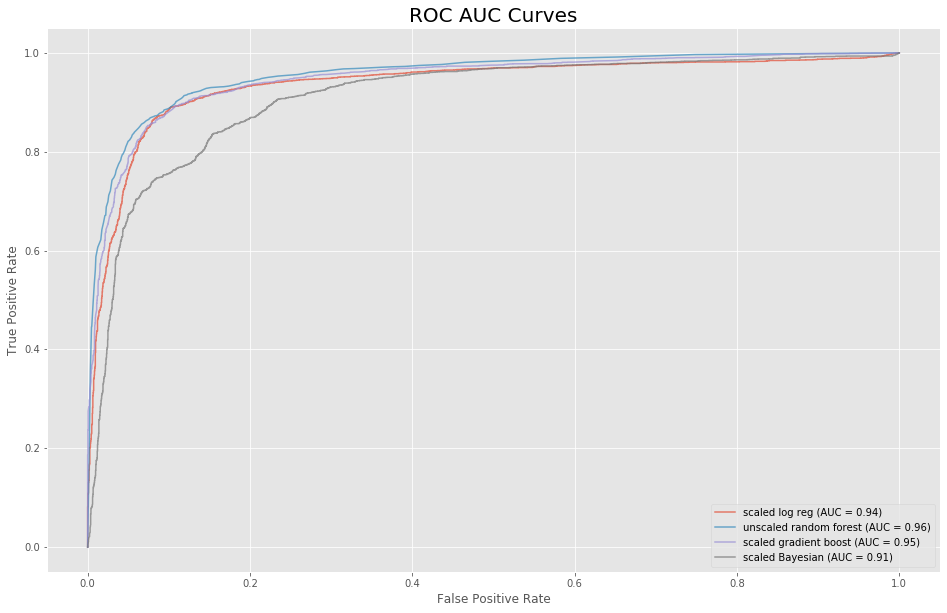

In [14]:
fig,ax = plt.subplots(figsize=(16,10))

roc_auc_plot(ax, clfs, X_train, y_train, X_validation, y_validation)

## Feature engineering with a chosen model

##### Feature importances

In [55]:
onehot_cols = list(lrc_s.named_steps['transformer'].named_transformers_['categorical'].named_steps['encoder'].get_feature_names())
numeric_cols = list(num_features)
numeric_cols.extend(onehot_cols)

In [24]:
lrc_s.fit(X_train,y_train)['estimator'].coef_

array([[-2.34268298, -2.01823144,  3.53370147,  0.5450754 , -0.43835197,
        -0.08458634,  0.01241213, -0.01158535, -0.15299976,  0.15382653,
        -0.66767521,  0.66850198, -1.85565737,  1.85648414, -0.98553766,
         0.98636443, -0.41153076,  0.41235753, -0.08600673,  0.0868335 ]])

In [57]:
eli5.explain_weights(lrc_s.named_steps['estimator'],feature_names=numeric_cols)

Weight?,Feature
+3.534,xp
+1.856,x3_True
+1.222,<BIAS>
+0.986,x4_True
+0.669,x2_True
+0.545,totalKills
+0.412,x5_True
+0.154,x1_True
+0.087,x6_True
+0.012,x0_blue


In [54]:
rfc_u.fit(X_train,y_train)['estimator'].feature_importances_

array([0.07275667, 0.07148773, 0.06916156, 0.04566981, 0.07063852,
       0.04498521, 0.00564558, 0.00561445, 0.00636217, 0.00747053,
       0.06378283, 0.06098188, 0.20397152, 0.15620455, 0.0264569 ,
       0.04177074, 0.01411535, 0.01628099, 0.0091229 , 0.00752009])

In [34]:
import eli5

In [50]:
onehot_cols = list(rfc_u.named_steps['transformer'].named_transformers_['categorical'].named_steps['encoder'].get_feature_names())
numeric_cols = list(num_features)
numeric_cols.extend(onehot_cols)

In [52]:
eli5.explain_weights(rfc_u.named_steps['estimator'],top=20,feature_names=numeric_cols)

Weight,Feature
0.2165 ± 0.3683,x3_True
0.1573 ± 0.3449,x3_False
0.0755 ± 0.0577,totalDeaths
0.0729 ± 0.0426,totalGold
0.0701 ± 0.0492,xp
0.0686 ± 0.0379,level
0.0651 ± 0.1416,x2_False
0.0462 ± 0.1305,x2_True
0.0439 ± 0.0277,level_ups
0.0417 ± 0.0199,totalKills


## Tuning hyperparameters

## Confusion Matrix results